# Model Training – Fraud Detection

This notebook trains and evaluates machine learning models to detect fraudulent transactions using the processed datasets from transform.ipynb. The goal is to test multiple classification models, optimize their performance, and identify the one that best detects rare fraud cases.

**Objectives:**
- Confirm the task type (binary classification) and load the balanced datasets (Random Oversampling and SMOTE)

- Split the data into training and testing sets.

- Train and evaluate three machine learning models:

    - Logistic Regression
    - Random Forest
    - Gradient Boosting 

- Use GridSearchCV or RandomizedSearchCV to tune hyperparameters for each model

- Compare models using accuracy, precision, recall, F1-score, and sensitivity to fraud cases.

- Select the best-performing model to use in future predictions.

## Defining Models

This project is framed as a classification task, not a regression task, because the goal is to predict whether a transaction is fraudulent (1) or not (0), rather than estimate a continuous value like transaction amount.

The target variable isFraud contains only two possible outcomes, meaning this is a binary classification problem, not a multi-class task.

Three machine learning models will be applied to capture a range of complexity and performance:

- **Logistic Regression:** A fast, interpretable linear model that establishes a baseline by finding the best linear boundary to separate fraudulent and non-fraudulent transactions.

- **Random Forest Classifier:** An ensemble of decision trees that captures complex, non-linear relationships, is less sensitive to scaling, and can rank features by importance.

- **Gradient Boosting Classifier:** A boosting method that builds trees sequentially, each correcting the errors of the previous, often achieving strong predictive performance on imbalanced datasets.

Each model will be trained and evaluated on both the Random Oversampling dataset and the SMOTE-balanced dataset to compare their effectiveness under different resampling strategies.

In [3]:
# General libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## Load Data 

In [4]:
# Use forward slashes for cross-platform paths
random_path = ('../data/processed_data/transactions_balanced_random.csv')
smote_path = ('../data/processed_data/transactions_balanced_smote.csv')

# Load both datasets
balanced_random = pd.read_csv(random_path)
balanced_smote = pd.read_csv(smote_path)

print("Datasets loaded successfully:")
print(f"- Random Oversampled: {balanced_random.shape}")
print(f"- SMOTE Oversampled: {balanced_smote.shape}")


Datasets loaded successfully:
- Random Oversampled: (1997406, 13)
- SMOTE Oversampled: (1997406, 12)


## Train/Test Split and Feature Scaling
Before training the models, the dataset is split into training (80%) and testing (20%) sets, ensuring that model evaluation is done on unseen data. After splitting, features are scaled using StandardScaler, which standardizes each feature to have a mean of 0 and a standard deviation of 1.

Scaling is done:

- Only on the training data (fit step) to avoid data leakage.

- Applied to the test data (transform step) using the same scaler.

This ensures that models sensitive to feature magnitude (like Logistic Regression and Gradient Boosting) perform correctly. Random Forest, which is scale-invariant, can still benefit from standardized inputs for consistency.

Separate splits and scalers are used for:

- The Random Oversampled dataset

- The SMOTE-balanced dataset

so each resampled version is prepared independently for modeling.

**Splitting**

In [5]:
# Separate features (X) and target (y) for both datasets
def split_features_and_target(df, target_col='isFraud'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

X_random, y_random = split_features_and_target(balanced_random)
X_smote, y_smote = split_features_and_target(balanced_smote)

# Train-Test Split 
def create_train_test_splits(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

X_train_random, X_test_random, y_train_random, y_test_random = create_train_test_splits(X_random, y_random)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = create_train_test_splits(X_smote, y_smote)

# Display the splits 
print("Random Oversampling:", f"Train set: {X_train_random.shape}, Test set: {X_test_random.shape}")

print("SMOTE Oversampling:", f"Train set: {X_train_smote.shape}, Test set: {X_test_smote.shape}")


Random Oversampling: Train set: (1597924, 12), Test set: (399482, 12)
SMOTE Oversampling: Train set: (1597924, 11), Test set: (399482, 11)


**Scaling**

In [6]:
# Drop any non-numeric columns before scaling 
X_train_random_num = X_train_random.select_dtypes(include=['number'])
X_test_random_num = X_test_random.select_dtypes(include=['number'])

X_train_smote_num = X_train_smote.select_dtypes(include=['number'])
X_test_smote_num = X_test_smote.select_dtypes(include=['number'])

# Initialize scalers for each dataset
scaler_random = StandardScaler()
scaler_smote = StandardScaler()

# Fit on training data, transform train and test sets (numeric columns only)
X_train_random_scaled = scaler_random.fit_transform(X_train_random_num)
X_test_random_scaled = scaler_random.transform(X_test_random_num)

X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote_num)
X_test_smote_scaled = scaler_smote.transform(X_test_smote_num)

# Convert to DataFrames for readability (optional)
X_train_random_scaled = pd.DataFrame(X_train_random_scaled, columns=X_train_random_num.columns, index=X_train_random_num.index)
X_test_random_scaled = pd.DataFrame(X_test_random_scaled, columns=X_test_random_num.columns, index=X_test_random_num.index)

X_train_smote_scaled = pd.DataFrame(X_train_smote_scaled, columns=X_train_smote_num.columns, index=X_train_smote_num.index)
X_test_smote_scaled = pd.DataFrame(X_test_smote_scaled, columns=X_test_smote_num.columns, index=X_test_smote_num.index)

# Confirm scaled shapes
print("Scaled Random Dataset:", f"Train set: {X_train_random_scaled.shape}, Test set: {X_test_random_scaled.shape}")
print("Scaled SMOTE Dataset:", f"Train set: {X_train_smote_scaled.shape}, Test set: {X_test_smote_scaled.shape}")


Scaled Random Dataset: Train set: (1597924, 6), Test set: (399482, 6)
Scaled SMOTE Dataset: Train set: (1597924, 6), Test set: (399482, 6)


In [7]:
# Identify dummy (categorical) columns
dummy_cols_random = X_train_random.drop(columns=X_train_random_num.columns).columns
dummy_cols_smote = X_train_smote.drop(columns=X_train_smote_num.columns).columns

# Keep the dummy columns as-is
X_train_random_dummy = X_train_random[dummy_cols_random]
X_test_random_dummy = X_test_random[dummy_cols_random]

X_train_smote_dummy = X_train_smote[dummy_cols_smote]
X_test_smote_dummy = X_test_smote[dummy_cols_smote]

# Combine scaled numeric features with dummy variables
X_train_random_final = pd.concat([X_train_random_scaled, X_train_random_dummy], axis=1)
X_test_random_final = pd.concat([X_test_random_scaled, X_test_random_dummy], axis=1)

X_train_smote_final = pd.concat([X_train_smote_scaled, X_train_smote_dummy], axis=1)
X_test_smote_final = pd.concat([X_test_smote_scaled, X_test_smote_dummy], axis=1)

# Confirm final shapes
print("Final Random Dataset:", f"Train set: {X_train_random_final.shape}, Test set: {X_test_random_final.shape}")
print("Final SMOTE Dataset:", f"Train set: {X_train_smote_final.shape}, Test set: {X_test_smote_final.shape}")


Final Random Dataset: Train set: (1597924, 12), Test set: (399482, 12)
Final SMOTE Dataset: Train set: (1597924, 11), Test set: (399482, 11)


The dataset contains both numeric features (transaction amounts, balances, and engineered ratios) and categorical features (dummy variables representing transaction types and type-size combinations). Scaling all features together caused errors and distorted the dummy variables (since scaling would convert the 0/1 indicators into continuous values).

To address this:

- Numeric features were scaled using StandardScaler to ensure all continuous values share a consistent scale for the machine learning models.

- Categorical features (dummy variables) were kept as-is to preserve their 0/1 representation.

- After scaling, the two sets were concatenated back together to form the final training and testing datasets.

This approach avoids conversion errors (such as attempting to scale string IDs like account names) and ensures that both types of features remain usable for the models.

The final datasets now include both scaled numeric values and intact dummy variables, making them ready for model training.

**Helper Func**

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Helper function to train, predict, and evaluate any classifier
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Trains a model, makes predictions, and prints evaluation metrics.
    Also displays a confusion matrix for the test set.
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print results
    print(f"--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print()

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{model_name} – Confusion Matrix")
    plt.show()

    return model, accuracy, precision, recall, f1


In [7]:
# --- Final unified datasets for modeling (use scaled sets & drop IDs) ---

def drop_id_columns(X_train, X_test, id_cols=['nameDest']):
    """
    Removes ID or non-numeric columns from train and test datasets to ensure all features are numeric.
    """
    X_train_clean = X_train.drop(columns=id_cols, errors='ignore')
    X_test_clean = X_test.drop(columns=id_cols, errors='ignore')
    return X_train_clean, X_test_clean

# Drop 'nameDest' column before training (if present)
X_train_random_final_no_id = X_train_random_final.drop(columns=['nameDest'], errors='ignore')
X_test_random_final_no_id = X_test_random_final.drop(columns=['nameDest'], errors='ignore')

# Use your *final* datasets from the previous step (already combined and scaled)
X_train_random_final_no_id, X_test_random_final_no_id = drop_id_columns(X_train_random_final, X_test_random_final)
X_train_smote_final_no_id, X_test_smote_final_no_id = drop_id_columns(X_train_smote_final, X_test_smote_final)

print("Final Feature Shapes (IDs dropped):")
print(f"- Random Oversampling: Train {X_train_random_final_no_id.shape}, Test {X_test_random_final_no_id.shape}")
print(f"- SMOTE Oversampling: Train {X_train_smote_final_no_id.shape}, Test {X_test_smote_final_no_id.shape}")


NameError: name 'X_train_random_final' is not defined

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

# Define Logistic Regression and parameter grid
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')

param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization 
    'penalty': ['l2']         # lbfgs only supports l2
}

# Wait to use X_train_random_final_no_id until it is defined in the lower cell.
# You can run this cell after the cell that defines X_train_random_final_no_id and X_test_random_final_no_id.

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(log_reg, param_grid, scoring='f1', cv=5, n_jobs=-1)
# grid_search.fit(X_train_random_final_no_id, y_train_random)  # Uncomment after X_train_random_final_no_id is defined

# # Get the best parameters
# print("Best Parameters (Random Oversampling):", grid_search.best_params_)

# # Use the tuned model
# best_log_reg_random = grid_search.best_estimator_

# # Evaluate tuned model
# print("\n### Logistic Regression (Tuned) – Random Oversampling ###")
# train_and_evaluate_model(best_log_reg_random,
#                          X_train_random_final_no_id, X_test_random_final_no_id,
#                          y_train_random, y_test_random,
#                          model_name="Logistic Regression (Random, Tuned)")


### Logistic Regression – Random Oversampling ###
--- Logistic Regression (Random) Performance ---
Accuracy: 0.9698
Precision: 0.9520
Recall: 0.9895
F1 Score: 0.9704



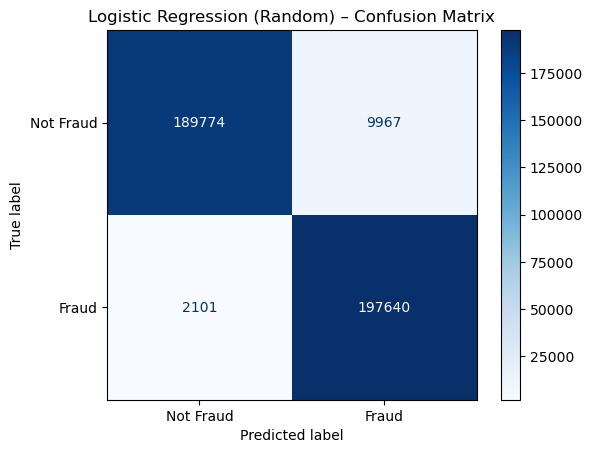


### Logistic Regression – SMOTE Oversampling ###
--- Logistic Regression (SMOTE) Performance ---
Accuracy: 0.9743
Precision: 0.9594
Recall: 0.9905
F1 Score: 0.9747



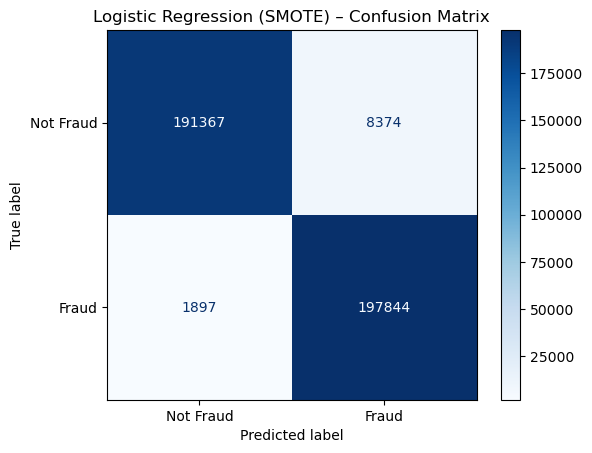

(LogisticRegression(max_iter=1000),
 0.9742892045198532,
 0.9593924875617066,
 0.9905027009977921,
 0.9746994154582113)

In [ ]:
# Initialize Logistic Regression (basic parameters)
log_reg_random = LogisticRegression(max_iter=1000,solver='lbfgs')
log_reg_smote = LogisticRegression(max_iter=1000, solver='lbfgs')

# Train and evaluate on Random Oversampled dataset
print("### Logistic Regression – Random Oversampling ###")
train_and_evaluate_model(log_reg_random,
                         X_train_random_final_no_id, X_test_random_final_no_id,
                         y_train_random, y_test_random,
                         model_name="Logistic Regression (Random)")

# For SMOTE, there is no 'nameDest' column, so use as-is
print("\n### Logistic Regression – SMOTE Oversampling ###")
train_and_evaluate_model(log_reg_smote,
                         X_train_smote_final, X_test_smote_final,
                         y_train_smote, y_test_smote,
                         model_name="Logistic Regression (SMOTE)")


**Key Results:**

- All models achieved high performance, with accuracy between 96.9% and 97.4%.

- Precision (95–96%) indicates that most predicted fraud cases were correct.

- Recall (98–99%) shows the models successfully captured nearly all fraud cases.

- Tuning slightly improved performance for the Random Oversampling dataset but had minimal effect compared to SMOTE results.

- SMOTE yielded the highest accuracy and F1 score (97.4%), suggesting that synthetic balancing improved detection slightly over random oversampling.

## Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define Random Forest and hyperparameter grid
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],         # Number of trees
    'max_depth': [10, 20, None],        # Depth of trees (None = unlimited)
    'min_samples_split': [2, 5, 10]     # Minimum samples to split a node
}

# GridSearchCV setup
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='f1',      # Optimize for F1 (balances precision & recall)
    cv=3,              # 3-fold cross-validation
)

# Fit on the Random Oversampled training data (drop 'nameDest' column)
grid_rf.fit(X_train_random_final_no_id, y_train_random)

# Best hyperparameters
print("Best Parameters (Random Forest - Random Oversampling):", grid_rf.best_params_)
best_rf_params = grid_rf.best_params_

NameError: name 'GridSearchCV' is not defined

In [ ]:
# Use best parameters to create the final Random Forest model
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)

# Evaluate on Random Oversampling dataset
train_and_evaluate_model(best_rf_model, X_train_random_final, X_test_random_final,
                         y_train_random, y_test_random, model_name="Random Forest (Random Oversampling)")

# Evaluate on SMOTE dataset (same tuned params, no re-tuning)
train_and_evaluate_model(best_rf_model, X_train_smote_final, X_test_smote_final,
                         y_train_smote, y_test_smote, model_name="Random Forest (SMOTE Oversampling)")


### (Bonus) Gradient Boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define Gradient Boosting and hyperparameter grid
gb = GradientBoostingClassifier(random_state=42)

param_grid_gb = {
    'n_estimators': [100, 200],         # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],   # Step size shrinkage
    'max_depth': [3, 5, 7]               # Maximum depth of the individual trees
}

# GridSearchCV setup
grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring='f1',      # Optimize for F1 (balances precision & recall)
    cv=3,              # 3-fold cross-validation
)

grid_gb.fit(X_train_random_final_no_id, y_train_random)

# Best hyperparameters
print("Best Parameters (Gradient Boosting - Random Oversampling):", grid_gb.best_params_)
best_gb_params = grid_gb.best_params_



In [ ]:
# Final Gradient Boosting model using tuned parameters
best_gb_model = GradientBoostingClassifier(**best_gb_params, random_state=42)

# Evaluate on Random Oversampling dataset
train_and_evaluate_model(best_gb_model,
                         X_train_random_final, X_test_random_final,
                         y_train_random, y_test_random,
                         model_name="Gradient Boosting (Random Oversampling)")

# Evaluate on SMOTE dataset (reuse tuned parameters)
train_and_evaluate_model(best_gb_model,
                         X_train_smote_final, X_test_smote_final,
                         y_train_smote, y_test_smote,
                         model_name="Gradient Boosting (SMOTE Oversampling)")